In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

In [36]:
# load the datasets
try:
    x_train = pd.read_parquet('data/x_train.parquet')
    x_test = pd.read_parquet('data/x_test.parquet')
    y_train = pd.read_parquet('data/y_train.parquet')['y_train']
    y_test = pd.read_parquet('data/y_test.parquet')['y_test']
    df = pd.read_csv('data/preprocessed_df.csv')
    print('Files successfully loaded!')
except FileNotFoundError:
    print('Files not found!')

Files successfully loaded!


In [3]:
# load the best model
if os.path.exists('models/XGBClassifier_best_model.pkl'):
    best_model = joblib.load('models/XGBClassifier_best_model.pkl')
    print('Best model successfully loaded!')
else:
    raise ValueError('Model not found!')

Best model successfully loaded!


In [4]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

In [5]:
# prediction model
from sklearn.calibration import CalibratedClassifierCV
calibrated_model = CalibratedClassifierCV(best_model,method='sigmoid',cv=cv)
calibrated_model.fit(x_train,y_train)

y_probs = calibrated_model.predict_proba(x_test)[:,1]
threshold = 0.2
y_pred = (y_probs >= threshold).astype(int)

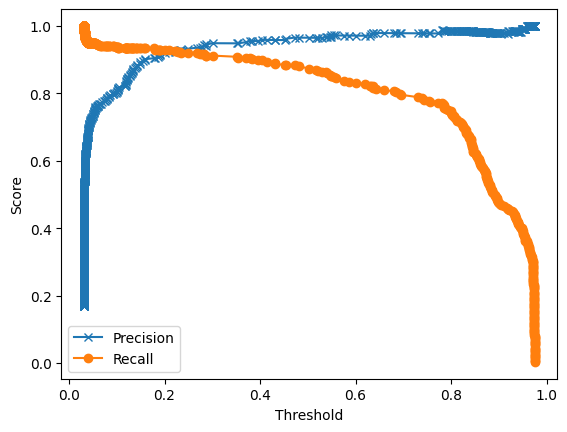

In [6]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], label="Precision",marker='x')
plt.plot(thresholds, recalls[:-1], label="Recall",marker='o')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()


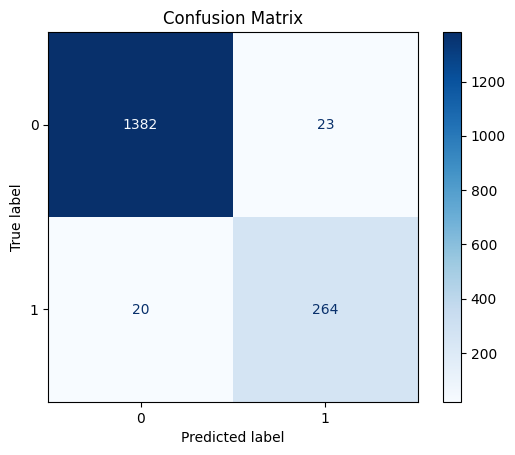

In [7]:
# confusion matrix - per-class misclassification
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('plots/confusion_matrix.png',bbox_inches='tight',dpi=300)
plt.show()

In [8]:
from sklearn.metrics import precision_score,recall_score,classification_report

In [9]:
# precision - of all the positives that were predicted, how many where actual positives?
print(f'Precision Score : {round(precision_score(y_test,y_pred),2) * 100}%')

Precision Score : 92.0%


In [10]:
# recall - of all the actual positives, how many did we catch?
print(f'Recall Score : {round(recall_score(y_test,y_pred),2)*100}%')

Recall Score : 93.0%


In [11]:
# classification report - summary report of the model
print('Classification Report\n',classification_report(y_test,y_pred))

Classification Report
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1405
           1       0.92      0.93      0.92       284

    accuracy                           0.97      1689
   macro avg       0.95      0.96      0.95      1689
weighted avg       0.97      0.97      0.97      1689



In [12]:
from sklearn.model_selection import learning_curve,LearningCurveDisplay,cross_val_score

In [13]:
# cross validation scores across five folds - checks for model stability on train set
cv_score = cross_val_score(best_model,x_train,y_train,cv=5,scoring='accuracy')
print('CV Score on Training Set\n')
print('cv_accuracy_score across 5 folds : ',cv_score)
print('mean_cv_score : ',cv_score.mean())
print('std_cv_score : ',cv_score.std())

CV Score on Training Set

cv_accuracy_score across 5 folds :  [0.94930292 0.96192893 0.95431472 0.94035533 0.92766497]
mean_cv_score :  0.9467133748946491
std_cv_score :  0.011825952020175404


In [14]:
# checks for model stability on test set
cv_score = cross_val_score(best_model,x_test,y_pred,cv=5,scoring='accuracy')
print('CV Score on Test Set\n')
print('cv_accuracy_score across 5 folds : ',cv_score)
print('mean_cv_score : ',cv_score.mean())
print('std_cv_score : ',cv_score.std())

CV Score on Test Set

cv_accuracy_score across 5 folds :  [0.91715976 0.9112426  0.92307692 0.93195266 0.94065282]
mean_cv_score :  0.9248169543307639
std_cv_score :  0.010465335407261231


<Figure size 1000x700 with 0 Axes>

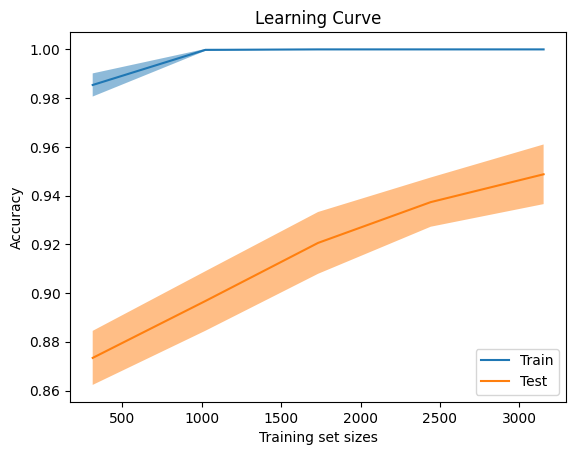

In [15]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model,x_train,y_train,cv = 5, scoring='accuracy',shuffle=True,random_state=42,n_jobs= -1
)
plt.figure(figsize=(10,7))
disp = LearningCurveDisplay(
    train_sizes=train_sizes,
    train_scores=train_scores,
    test_scores=test_scores
)
disp.plot()
plt.title('Learning Curve')
plt.xlabel('Training set sizes')
plt.ylabel('Accuracy')
plt.show()

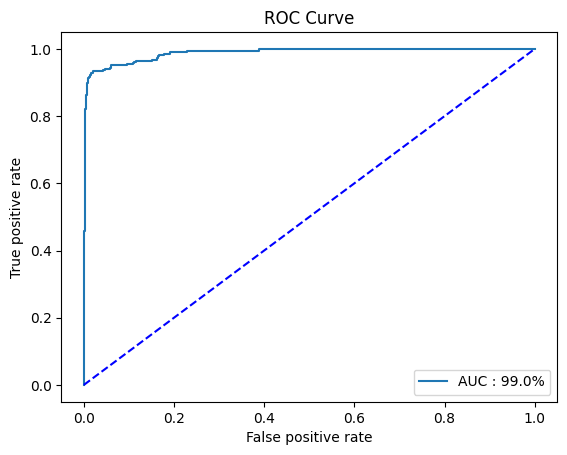

In [16]:
from sklearn.metrics import roc_auc_score,roc_curve
# the rate at which model classifiers model well - determines whether model is really learning or just randomly guessing
fpr,tpr,threshold = roc_curve(
    y_test,y_probs
)
auc_score = roc_auc_score(y_test,y_probs)
plt.plot(fpr,tpr,label=f'AUC : {round(auc_score,2)*100}%')
plt.plot([0,1],[0,1],linestyle='--',color='blue')
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

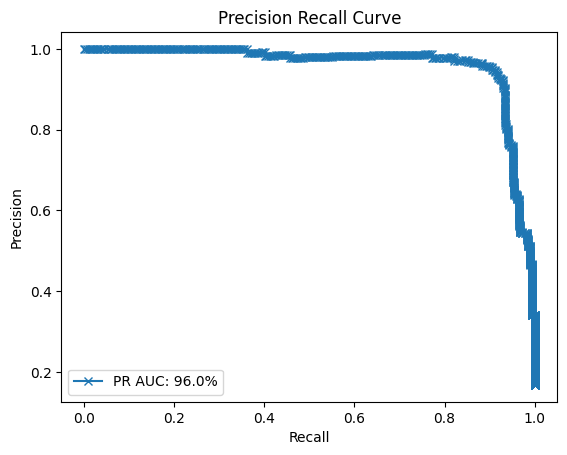

In [17]:
# precision recall tradeoff
from sklearn.metrics import precision_recall_curve,average_precision_score
precision,recall,threshold = precision_recall_curve (
    y_test,y_probs
)
pr_auc = average_precision_score(y_test,y_probs)
plt.plot(recall,precision,label=f'PR AUC: {round(pr_auc,2)*100}%',marker='x')
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

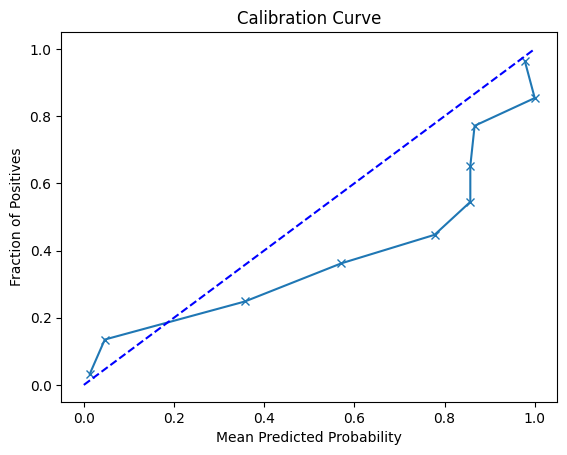

In [18]:
# compares how well predicted probabilties match real outcomes
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(
    y_test,y_probs, n_bins=10, strategy='uniform'
)
plt.plot(prob_true, prob_pred, marker= 'x')
plt.plot([0,1],[0,1],linestyle='--',color='blue')
plt.title('Calibration Curve')
plt.xlabel("Mean Predicted Probability")
plt.ylabel('Fraction of Positives')
plt.show()

In [19]:
from sklearn.metrics import brier_score_loss
print('Brier score loss : ',brier_score_loss(y_test,y_pred))

Brier score loss :  0.02545885139135583


In [20]:
from sklearn.metrics import log_loss
print('Log loss : ',log_loss(y_test,y_pred))

Log loss :  0.9176300152350728


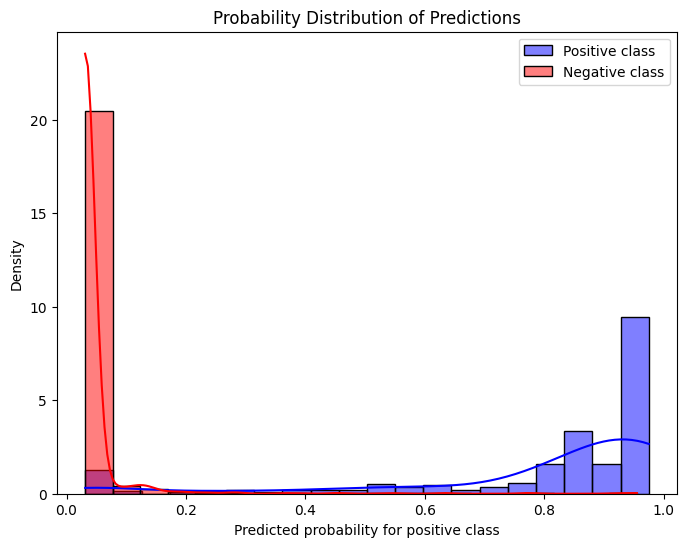

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Probabilities for positive class

plt.figure(figsize=(8,6))
sns.histplot(y_probs[y_test == 1], color="blue", label="Positive class", kde=True, stat="density", bins=20)
sns.histplot(y_probs[y_test == 0], color="red", label="Negative class", kde=True, stat="density", bins=20)

plt.xlabel("Predicted probability for positive class")
plt.ylabel("Density")
plt.title("Probability Distribution of Predictions")
plt.legend()
plt.show()


In [22]:
from sklearn.metrics import matthews_corrcoef
print('Matthews coefficient : ',matthews_corrcoef(y_test,y_pred))

Matthews coefficient :  0.909393360431276


In [23]:
from sklearn.metrics import cohen_kappa_score
print('Cohen Kappa Score : ',cohen_kappa_score(y_test,y_pred))

Cohen Kappa Score :  0.9093751832723361


In [73]:
# error analysis
errors = y_pred != y_test
x_test[errors]

error_analysis = pd.DataFrame(x_test.copy())
error_analysis["y_true"] = y_test
error_analysis["y_pred"] = y_pred
error_analysis['is_error'] = errors.astype(int)
# return only rows which were misclassified
error = error_analysis[error_analysis['is_error'] == 1]
error

,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,...,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,y_true,y_pred,is_error
1,1.0,Phone,3,16.0,Credit Card,Male,3.0,4,Mobile Phone,1,...,3,0,14.0,1.0,2.0,1.0,136,1,0,1
42,9.0,Computer,3,16.0,Credit Card,Male,2.0,3,Fashion,2,...,2,0,14.0,1.0,9.0,7.0,200,0,1,1
98,20.0,Phone,1,NaN,COD,Male,2.0,3,Mobile,3,...,5,0,24.0,1.0,1.0,0.0,125,1,0,1
139,1.0,Mobile Phone,1,9.0,UPI,Male,3.0,4,Mobile Phone,3,...,8,1,20.0,1.0,2.0,3.0,165,0,1,1
197,0.0,Phone,1,13.0,Debit Card,Male,3.0,3,Laptop & Accessory,3,...,2,0,18.0,1.0,1.0,1.0,149,1,0,1
239,1.0,Mobile Phone,1,30.0,Credit Card,Male,3.0,3,Mobile Phone,2,...,3,1,12.0,1.0,2.0,5.0,152,0,1,1
253,1.0,Mobile Phone,3,14.0,Debit Card,Male,3.0,5,Fashion,2,...,11,0,22.0,2.0,NaN,2.0,241,0,1,1
260,0.0,Phone,1,7.0,CC,Male,NaN,3,Mobile,5,...,1,0,13.0,7.0,7.0,6.0,129,0,1,1
303,1.0,Computer,1,12.0,Credit Card,Female,3.0,5,Mobile Phone,3,...,3,1,15.0,1.0,2.0,8.0,149,1,0,1
317,4.0,Mobile Phone,1,8.0,Credit Card,Female,2.0,5,Mobile Phone,1,...,2,1,11.0,0.0,1.0,0.0,111,0,1,1


In [33]:
pd.crosstab(error_analysis['MaritalStatus'],error_analysis['is_error'],normalize=True)*100

is_error,0,1
MaritalStatus,,
Divorced,15.216104,0.296033
Married,49.970397,1.243339
Single,32.267614,1.006513


In [35]:
pd.crosstab(error_analysis['PreferedOrderCat'],error_analysis['is_error'],normalize=True) *100

is_error,0,1
PreferedOrderCat,,
Fashion,13.143872,0.414446
Grocery,7.045589,0.000000
Laptop & Accessory,36.944938,0.355240
Mobile,13.795145,0.473653
Mobile Phone,21.314387,1.184133
Others,5.210184,0.118413


In [ ]:
# feature error analysis for preferedordercat - shows counts, number of errros and error rates
error_rate = error_analysis.groupby('PreferedOrderCat')['is_error'].mean()
counts = error_analysis.groupby('PreferedOrderCat')['is_error'].count()
errors = error_analysis.groupby('PreferedOrderCat')['is_error'].sum()
summary = pd.DataFrame({
    'error_rate' : error_rate,
    'counts' : counts,
    'errors' : errors
})
summary

,error_rate,counts,errors
PreferedOrderCat,,,
Fashion,0.030568,229,7
Grocery,0.000000,119,0
Laptop & Accessory,0.009524,630,6
Mobile,0.033195,241,8
Mobile Phone,0.052632,380,20
Others,0.022222,90,2


In [ ]:
num_features = error_analysis.select_dtypes(include='number').columns.drop('is_error')
# mean/median difference
mean_diff = error_analysis.groupby('is_error')[num_features].mean().T
median_diff = error_analysis.groupby('is_error')[num_features].median().T

# correlation with error
correlations = error_analysis[num_features].corrwith(error_analysis['is_error']).sort_values(ascending=False)

print('Mean Difference : \n',mean_diff)
print('\nMedian Diff : \n',median_diff)
print('\nCorrelation with error : \n',correlations)

Mean Difference : 
 is_error                              0           1
Tenure                        10.394636    5.000000
CityTier                       1.640340    1.372093
WarehouseToHome               15.560328   16.414634
HourSpendOnApp                 2.935587    2.974359
NumberOfDeviceRegistered       3.677400    3.883721
SatisfactionScore              3.078372    3.000000
NumberOfAddress                4.239976    3.953488
Complain                       0.291009    0.372093
OrderAmountHikeFromlastYear   15.798206   15.975610
CouponUsed                     1.719008    2.162791
OrderCount                     3.008254    3.571429
DaySinceLastOrder              4.543115    4.119048
CashbackAmount               177.938639  167.069767

Median Diff : 
 is_error                         0      1
Tenure                         9.0    1.0
CityTier                       1.0    1.0
WarehouseToHome               13.0   15.0
HourSpendOnApp                 3.0    3.0
NumberOfDeviceRegistered 

IndexError: index 1319 is out of bounds for axis 0 with size 43

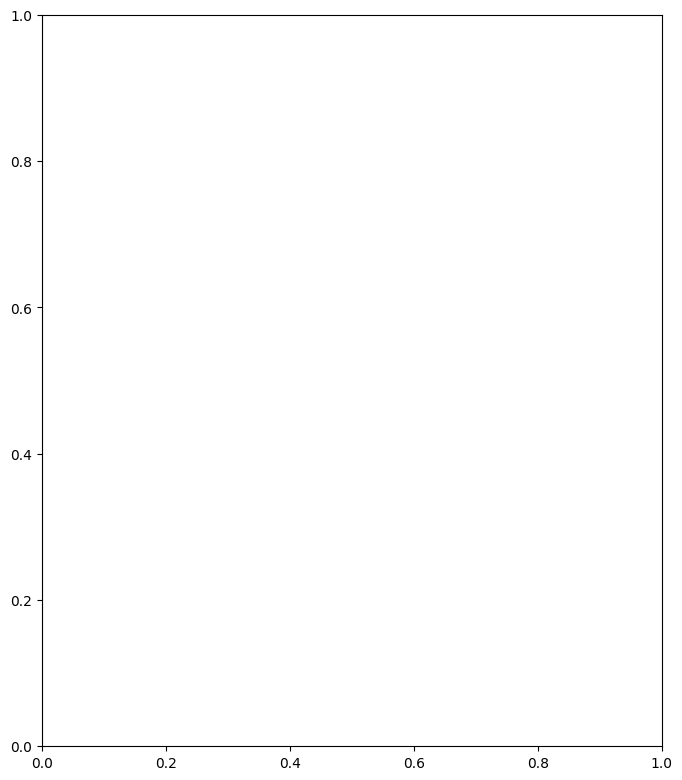

In [26]:
import shap
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
x_test_transformed = best_model.named_steps['preprocessor'].transform(x_test)
shap_values = explainer.shap_values(x_test_transformed)
shap.summary_plot(shap_values,x_test_transformed[errors])

In [27]:
#compare feature distributions
error_analysis = pd.DataFrame(x_test.copy())
error_analysis['is_error'] = errors.astype(int)
error_analysis

feature_means = error_analysis.groupby('is_error').mean().T
# feature_means['difference'] = feature_means[1] - feature_means[0]
# feature_means.sort_values(by='difference',key=abs,ascending=False)

TypeError: agg function failed [how->mean,dtype->object]

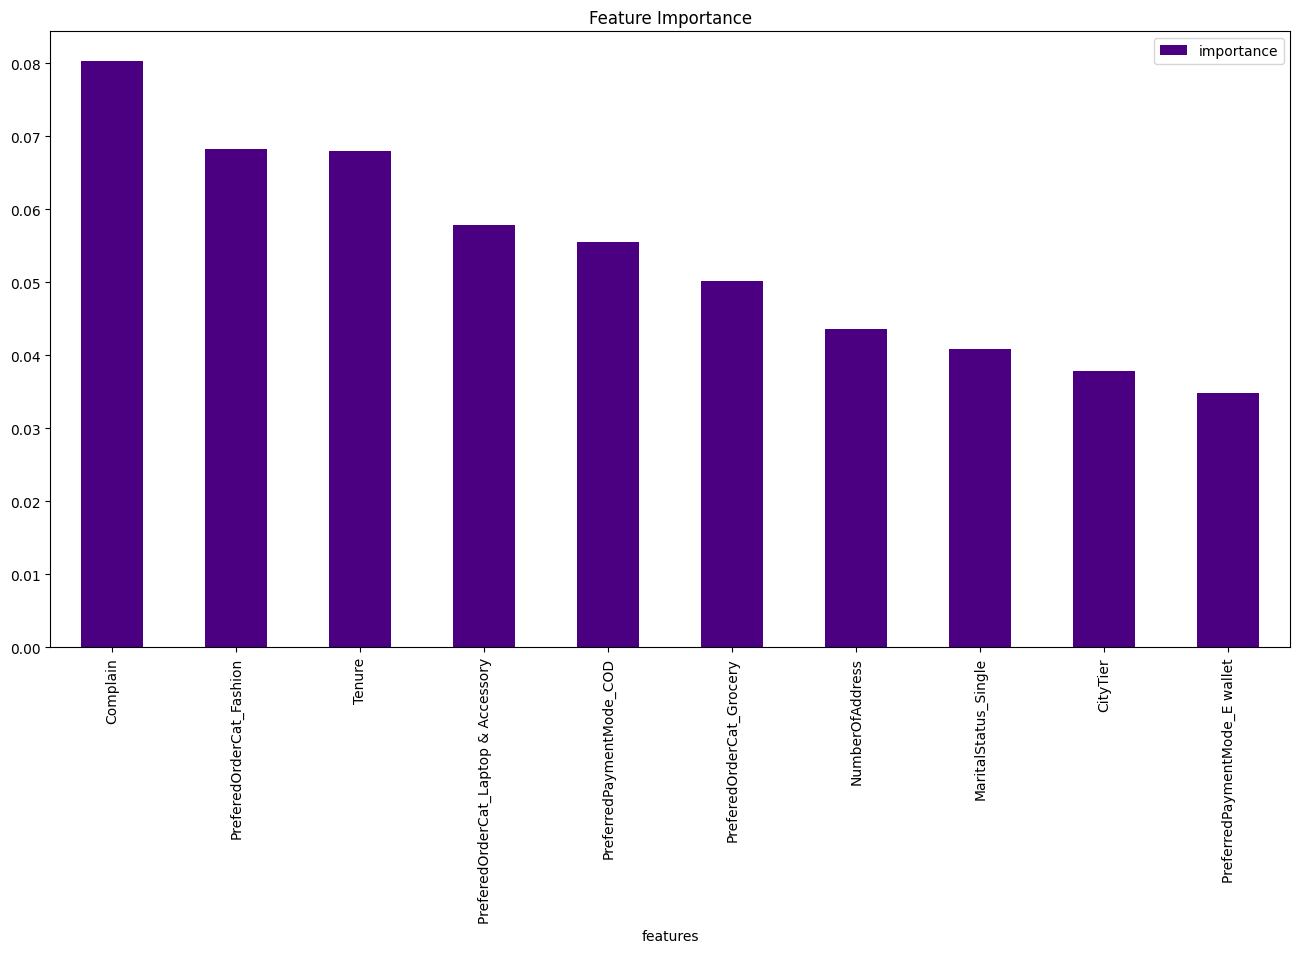

In [28]:
feature_names = best_model.named_steps.get('preprocessor',None).get_feature_names_out() # get feature names
importance = best_model.named_steps.get('classifier',None).feature_importances_ # get feature importance

feature_imp = pd.DataFrame({
    'features' : feature_names,
    'importance' : importance
}).sort_values(by='importance',ascending=False).head(10).plot.bar(x='features',y='importance',figsize=(16,8),color='indigo')
plt.title('Feature Importance')
plt.savefig('plots/feature_importance.png',bbox_inches='tight',dpi=300)
plt.show()

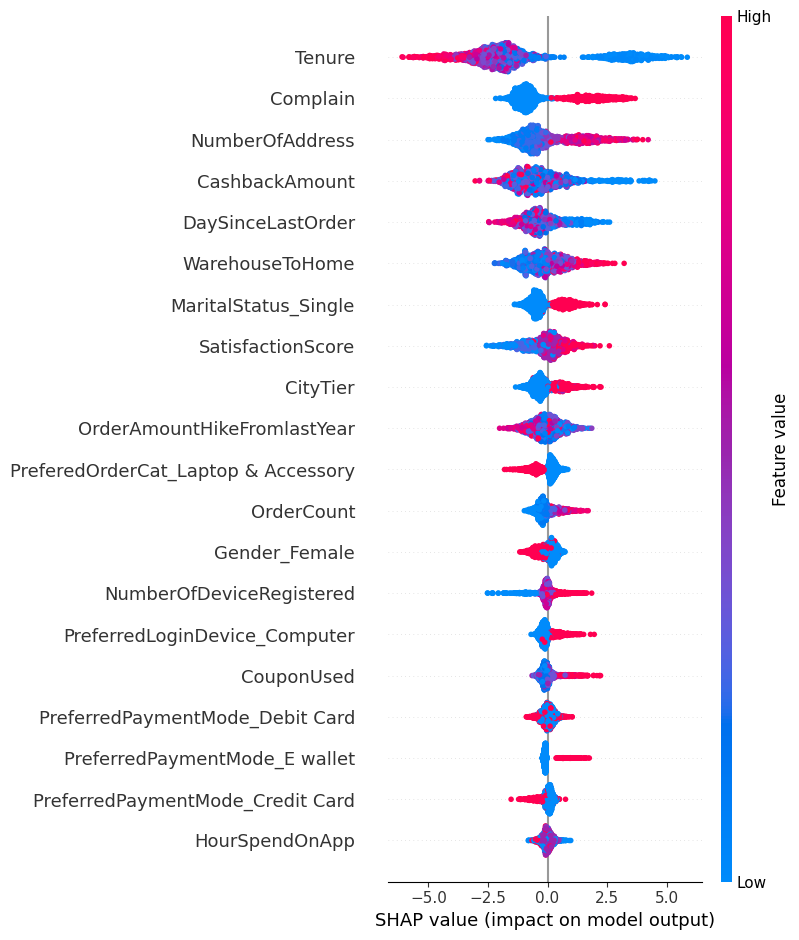

In [29]:
import shap
x_test_transformed = best_model.named_steps.get('preprocessor',None).transform(x_test)
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer(x_test_transformed)

plt.figure(figsize=(20,7))
shap.summary_plot(shap_values,x_test_transformed,feature_names=feature_names,show=False)
plt.savefig('plots/shap_summary.png',bbox_inches='tight',dpi=300)
plt.show()